In [9]:
import torchvision

from torch import cuda, device, Tensor
from src.plots import plot_vae_training_result, plot_cifar_image
from src.vae.cifar_vae import ConditionalVae
from src.image_classifier.image_classifier import CIFAR10Classifier

device = device('cuda' if cuda.is_available() else 'cpu')

In [10]:
# convert data to a normalized torch.FloatTensor
# https://github.com/kuangliu/pytorch-cifar/issues/19
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

training_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_train', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_test', train=False, download=True, transform=transform)

print(training_data)
print(testing_data)

input = training_data.data[:50000]
labels = training_data.targets[:50000]

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/CIFAR10_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/CIFAR10_test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [11]:
# Train VAE
vae = ConditionalVae(dim_encoding=100).to(device)

vae_model, vae_loss_li, kl_loss_li = vae.train_model(
    training_data=training_data,
    batch_size=32,
    epochs=10,
    beta=20.0,
    learning_rate=0.001
)

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10


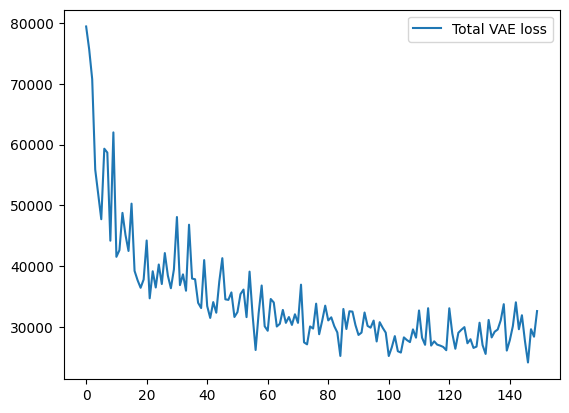

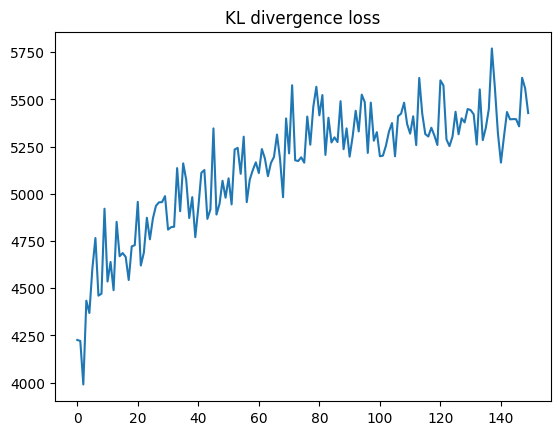

In [12]:
# move tensors to cpu before converting to np array
np_kl_loss_li = []

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())

# plot results
plot_vae_training_result(
    input=input,
    labels=labels,
    vae_model=vae_model,
    vae_loss_li=vae_loss_li,
    kl_loss_li=np_kl_loss_li
)

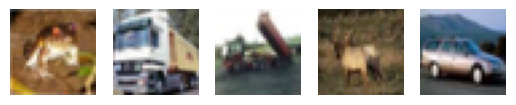

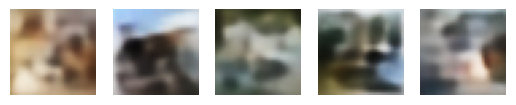

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# check output
n_samples = 5

samples = training_data.data[:n_samples]
plot_cifar_image(samples)

# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# (n_samples, 3, 32, 32)
output = vae.generate_data(n_samples=n_samples, target_label=1)

# plt.imshow(np.transpose(output[0].cpu().numpy(), (1, 2, 0)), cmap='gray')

# vae expects permuted input of (<batch_size, channels, height, width>)
output = output.permute(0, 2, 3, 1).cpu().detach().numpy()

assert output.shape == (n_samples, 32, 32, 3)

plot_cifar_image(output)

In [14]:
# train classifier for performance evaluation
classifier = CIFAR10Classifier().to(device)

classifier.train_model(training_data, batch_size=32, learning_rate=0.01, epochs=10)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Epoch done:  6
Epoch done:  7
Epoch done:  8
Epoch done:  9
Epoch done:  10
Test accuracy:  0.6917


In [27]:
n_samples = 100
target_label = 2
x = vae.generate_data(n_samples=n_samples, target_label=target_label)
labels = classifier.generate_labels(x.to(device))

count = 0

for label in labels:
    if label == target_label:
        count += 1

print("Accuracy: ", count / n_samples)

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 

In [8]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)